In [1]:
!pip install numpy torch torchvision matplotlib kagglehub

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 54.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 3.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 94.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 100.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 4.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 6.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import kagglehub
from modules.UNet import UNet
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F

In [3]:
path = kagglehub.dataset_download("humansintheloop/teeth-segmentation-on-dental-x-ray-images")

print("Path to dataset files:", path)

100%|██████████| 4.14G/4.14G [02:19<00:00, 31.8MB/s]

Extracting files...


Path to dataset files: /home/elicer/.cache/kagglehub/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images/versions/1


In [21]:
# 사전 정의된 픽셀 값 매핑 (원본 픽셀 값 -> 0~31 사이의 라벨 값으로 변환)
EXPECTED_MAPPING = {
    0: 0,   15: 1,   29: 2,   38: 3,   53: 4,   67: 5,   75: 6,   76: 7,
    79: 8,  90: 9,   91: 10, 104: 11, 105: 12, 113: 13, 128: 14, 142: 15,
  150: 16, 151: 17,  164: 18, 166: 19, 179: 20, 188: 21, 192: 22, 202: 23,
  205: 24, 223: 25,  226: 26, 251: 27, 255: 28, 240: 29, 250: 30, 245: 31
}

def map_mask_fixed(mask):
    # mask는 numpy 배열이어야 합니다.
    mapped = np.zeros_like(mask, dtype=np.int64)
    for orig_val, target in EXPECTED_MAPPING.items():
        mapped[mask == orig_val] = target
    unique_vals = np.unique(mask)
    for val in unique_vals:
        if val not in EXPECTED_MAPPING:
            raise ValueError(f"Mask contains unexpected value {val}. Expected keys: {list(EXPECTED_MAPPING.keys())}")
    return mapped

# albumentations를 이용한 증강 파이프라인 정의 (추가 대상: mask)
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.Normalize(mean=[0.3439, 0.3439, 0.3439], std=[0.2127, 0.2127, 0.2127]),
    ToTensorV2()
], additional_targets={'mask': 'mask'})

val_test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.3439, 0.3439, 0.3439], std=[0.2127, 0.2127, 0.2127]),
    ToTensorV2()
], additional_targets={'mask': 'mask'})

class XRayDataset(Dataset):
    """
    X-ray 이미지와 해당 마스크를 로드하는 Dataset 클래스.
    """
    def __init__(self, images_dir, masks_dir, transform):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_ids = os.listdir(images_dir)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.images_dir, image_id)
        mask_id = os.path.splitext(image_id)[0] + ".png"
        mask_path = os.path.join(self.masks_dir, mask_id)

        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))

        # albumentations를 통해 image와 mask에 동일한 증강을 적용
        augmented = self.transform(image=image, mask=mask)
        image = augmented["image"]
        # ToTensorV2가 적용되면 mask도 tensor 형식이 되지만, 픽셀 값은 그대로입니다.
        # 이후 map_mask_fixed 함수를 적용하여 클래스 매핑을 진행합니다.
        mask = augmented["mask"].numpy()
        mask = torch.as_tensor(map_mask_fixed(mask), dtype=torch.long)

        return image, mask

In [22]:
# 데이터셋 경로 (실제 경로로 수정)
"""
images_dir = '/home/elicer/.cache/kagglehub/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images/versions/1/Teeth Segmentation PNG/d2/img'
masks_dir = '/home/elicer/.cache/kagglehub/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images/versions/1/Teeth Segmentation PNG/d2/masks_machine'
"""
images_dir = '/home/elicer/.cache/kagglehub/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images/versions/1/Teeth Segmentation PNG/d2/img'
masks_dir = '/home/elicer/.cache/kagglehub/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images/versions/1/Teeth Segmentation PNG/d2/masks_machine'
full_dataset = XRayDataset(images_dir, masks_dir, transform=train_transform)


In [23]:
# 데이터 분할: 70% 학습, 15% 검증, 15% 테스트
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [24]:
# 검증, 테스트 데이터셋은 증강 없이 적용
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

In [25]:
# DataLoader 생성
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [26]:
# 일정 에포크 이상 검증 성능이 개선되지 않으면 학습을 중지하는 EarlyStopping 클래스
class EarlyStopping:
    def __init__(self, patience, verbose, delta):
        """
        Args:
            patience : 검증 성능이 개선되지 않는 최대 에포크 수.
            verbose : True이면 트리거 실행까지 남은 에포크 수 표시.
            delta : 최소 loss 감소량
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [27]:
def iou_score(pred, target, num_classes):
    """
    예측 마스크와 정답 마스크에 대해 클래스별 IoU를 계산한 후 평균 IoU를 반환.
    pred, target: (B, H, W) 텐서, num_classes: 클래스 수
    """
    pred = pred.view(-1)
    target = target.view(-1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).float().sum().item()
        union = pred_inds.float().sum().item() + target_inds.float().sum().item() - intersection
        # 해당 클래스가 존재하지 않으면 계산하지 않음.
        if union == 0:
            continue
        ious.append(intersection / union)
    if len(ious) == 0:
        return 0
    return np.mean(ious)

In [28]:
def dice_loss(pred, target, smooth=1e-6):
    """
    다중 클래스 segmentation을 위한 Dice 손실 함수.
    pred: (B, C, H, W) logits (모델의 출력)
    target: (B, H, W) 정수형 클래스 라벨
    """
    num_classes = pred.shape[1]
    # softmax 적용하여 확률 값으로 변환
    pred_soft = F.softmax(pred, dim=1)
    # ground truth를 one-hot 인코딩 (B, H, W) -> (B, H, W, C) 후 (B, C, H, W)로 변환
    target_one_hot = F.one_hot(target, num_classes=num_classes).permute(0, 3, 1, 2).float()
    
    # 각 클래스별로 교집합과 합집합 계산
    intersection = (pred_soft * target_one_hot).sum(dim=(2, 3))
    cardinality = pred_soft.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    dice_score = (2. * intersection + smooth) / (cardinality + smooth)
    
    # 평균 Dice 손실 (1 - Dice 점수)
    loss = 1 - dice_score.mean()
    return loss

class CombinedLoss(nn.Module):
    """
    Cross Entropy 손실과 Dice 손실의 결합 손실 함수.
    weight_ce와 weight_dice로 각 손실의 가중치를 조절할 수 있습니다.
    """
    def __init__(self, weight_ce=1.0, weight_dice=1.0):
        super(CombinedLoss, self).__init__()
        self.weight_ce = weight_ce
        self.weight_dice = weight_dice
        self.ce = nn.CrossEntropyLoss()
    
    def forward(self, pred, target):
        ce_loss = self.ce(pred, target)
        d_loss = dice_loss(pred, target)
        return self.weight_ce * ce_loss + self.weight_dice * d_loss

In [31]:
# 모델, optimizer, loss, device 설정
num_classes = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6) 
criterion = CombinedLoss(weight_ce=1.0, weight_dice=1.0)
best_iou = 0.0

In [32]:
# ReduceLRONPlateau 스케줄러, EarlyStopping 객체 생성
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=15, verbose=True, delta=0.001)

In [33]:
# 현재 사용중인 디바이스 출력
if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"현재 사용 중인 GPU: {device_name}")
else:
    print("CUDA 사용 불가, CPU 사용 중!")

현재 사용 중인 GPU: NVIDIA A100 80GB PCIe


In [34]:
# 학습 및 검증 루프
num_epochs = 200
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    total_iou = 0.0
    count = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            # 예측 마스크 (각 픽셀마다 확률이 가장 높은 클래스 선택)
            preds = torch.argmax(outputs, dim=1)
            batch_iou = iou_score(preds, masks, num_classes)
            total_iou += batch_iou
            count += 1
    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = total_iou / count
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}")

    # 체크포인트: 현재 epoch의 IoU가 최고 성능보다 좋으면 모델 저장
    if avg_val_iou > best_iou:
        best_iou = avg_val_iou
        torch.save(model.state_dict(), "best_model_checkpoint.pth")
        print("Best model saved!")

    # (원래 loss 기반 EarlyStopping 코드는 그대로 사용하거나 IoU 기반으로 변경 가능)
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break


Epoch 1/200, Train Loss: 2.8009, Val Loss: 1.9999, Val IoU: 0.0300
Best model saved!
Epoch 2/200, Train Loss: 1.9173, Val Loss: 1.6597, Val IoU: 0.0300
Epoch 3/200, Train Loss: 1.7368, Val Loss: 1.6369, Val IoU: 0.0300
Epoch 4/200, Train Loss: 1.6987, Val Loss: 1.6335, Val IoU: 0.0300
Epoch 5/200, Train Loss: 1.7011, Val Loss: 1.6080, Val IoU: 0.0300
Epoch 6/200, Train Loss: 1.6712, Val Loss: 1.6006, Val IoU: 0.0300
Epoch 7/200, Train Loss: 1.6495, Val Loss: 1.5917, Val IoU: 0.0300
Epoch 8/200, Train Loss: 1.6331, Val Loss: 1.5653, Val IoU: 0.0300
Epoch 9/200, Train Loss: 1.6141, Val Loss: 1.5659, Val IoU: 0.0300
Best model saved!
EarlyStopping counter: 1 out of 15
Epoch 10/200, Train Loss: 1.5984, Val Loss: 1.5471, Val IoU: 0.0302
Best model saved!
Epoch 11/200, Train Loss: 1.5910, Val Loss: 1.5304, Val IoU: 0.0317
Best model saved!
Epoch 12/200, Train Loss: 1.5754, Val Loss: 1.5200, Val IoU: 0.0360
Best model saved!
Epoch 13/200, Train Loss: 1.5622, Val Loss: 1.5125, Val IoU: 0.0376


In [35]:
# 테스트 과정
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()
avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 0.5347


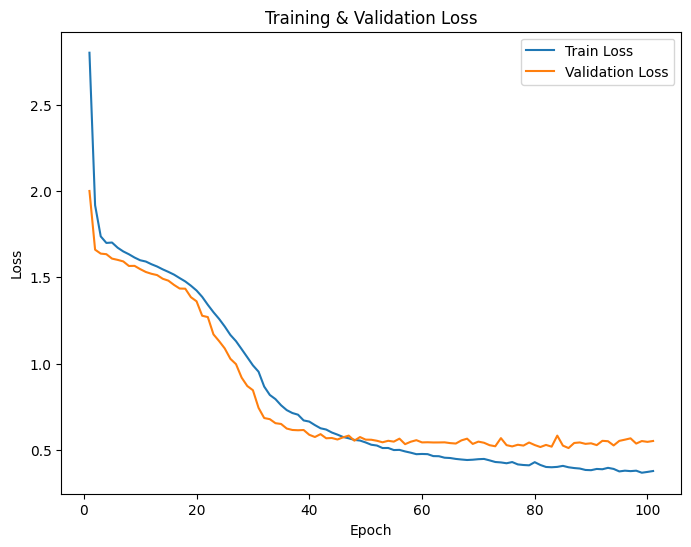

In [36]:
# 학습 및 검증 loss 그래프 그리기
epochs = len(train_losses)
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

Random test sample index: 61


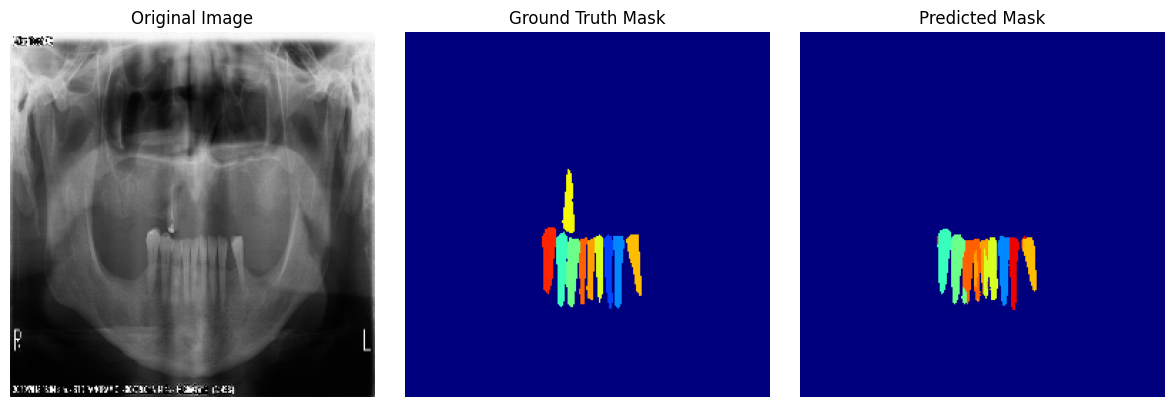

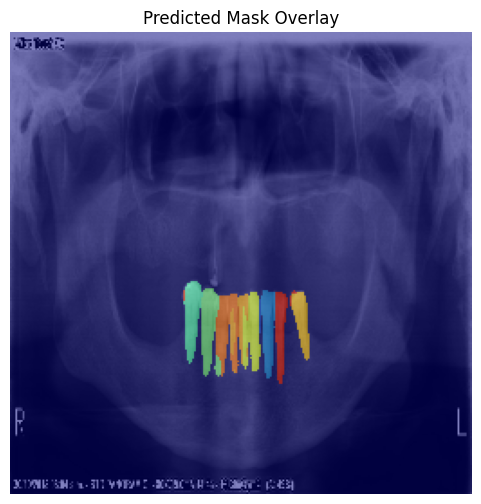

In [63]:
# 모델이 생성한 마스크 시각화 (테스트 데이터셋에서 랜덤 샘플 선택)
model.eval()
rand_idx = random.randint(0, len(test_dataset)-1)
print(f"Random test sample index: {rand_idx}")
image, true_mask = test_dataset[rand_idx]
image_tensor = image.unsqueeze(0).to(device)
with torch.no_grad():
    output = model(image_tensor)

# 모델 출력에서 가장 높은 값(가장 확률이 높은 클래스) 선택하여 마스크 생성    
# argmax를 사용해 채널 차원을 제거하고 2D 마스크로 변환
pred_mask = torch.argmax(output, dim=1).squeeze(0)

# 텐서를 (H, W, C) 형식의 numpy 배열로 변환
img_np = image.cpu().numpy().transpose(1, 2, 0)
mean = np.array([0.3439, 0.3439, 0.3439])
std = np.array([0.2127, 0.2127, 0.2127])

# 정규화 해제 (원래 픽셀 값으로 복원)
img_np = std * img_np + mean

# 값의 범위를 0~1로 제한하여 시각적으로 이상이 없도록 처리
img_np = np.clip(img_np, 0, 1)

# 실제 마스크 및 예측 마스크를 numpy 배열로 변환
true_mask_np = true_mask.cpu().numpy()
pred_mask_np = pred_mask.cpu().numpy()

# 원본 이미지, 실제 마스크, 예측 마스크 출력
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(true_mask_np, cmap='jet', vmin=0, vmax=num_classes-1)
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask_np, cmap='jet', vmin=0, vmax=num_classes-1)
plt.title("Predicted Mask")
plt.axis("off")
plt.tight_layout()
plt.show()

# 원본 이미지 위에 예측 마스크를 반투명하게 표시하는 오버레이 방식 출력 
plt.figure(figsize=(6, 6))
plt.imshow(img_np)  # 원본 이미지 표시
# 예측 마스크를 jet 컬러맵과 alpha=0.5로 오버레이
plt.imshow(pred_mask_np, cmap='jet', alpha=0.5, vmin=0, vmax=num_classes-1)
plt.title("Predicted Mask Overlay")
plt.axis("off")
plt.show()

In [18]:
# 모델 저장
torch.save(model.state_dict(), "Unet_segmentation_model.pth")

In [19]:
from IPython.display import FileLink

FileLink('Unet_segmentation_model.pth')

/home/elicer/Unet_segmentation_model.pth